In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy
# import tensorflow as tf
# from sklearn.manifold import TSNE
# import sompylib.sompy as SOM
from time import time
import random
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv
import os
import glob
from ipywidgets import interact, HTML, FloatSlider, fixed, IntSlider, HBox, VBox, interactive
import ipywidgets as widgets
%matplotlib inline
# print (plt.style.available)

In [3]:
# How to import the fmd module
from fdmlib import fdm
import sys,importlib
importlib.reload(fdm)
FdmSolver = fdm.FDM()


In [4]:
path = './Data/'
graph_id = 'stadium'
fn = path + '{}.npy'.format(graph_id)
Data_struct = np.load(fn,allow_pickle='TRUE').item()

## One idea for parametrization of the force densities
## trail members vs. deviation members

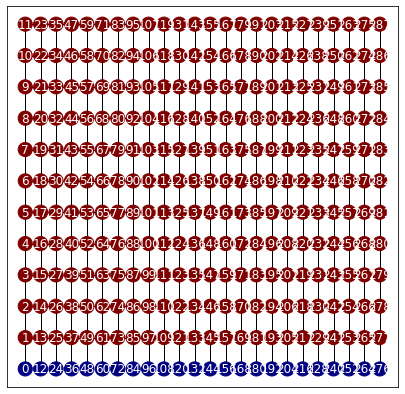

In [5]:
fig = plt.figure(figsize=(7,7))
free_nodes_mask = Data_struct['free_nodes_mask']
G = Data_struct['G']
all_poses = Data_struct['all_poses']
nx.draw_networkx(G,
             pos=all_poses,
             arrows=False,
             width = 1,
             with_labels=True,
             font_color='white',
             node_size=200,
             node_color=free_nodes_mask,
             cmap=plt.cm.jet,
             alpha=1)  

# The case of a stadium roof
- In addition to use of network centralities as a parametrization of the force densities, in other cases, depending on the case and the chosen topology, one can come up with different parametrizations. Below you see an example of a stadium roof, where the fixed points are lying on a circle. 

### For further details about this case, please look at the paper below or contact me via sevamoo@gmail.com
* Karla Saldana Ochoa, Patrick Ole Ohlbrock, Pierluigi D’acunto, Vahid Moosavi, beyond typologies, beyond optimization, IASS Annual Symposium 2019 - Structural Membranes 2019, Form and Force, 7–10 October 2019, Barcelona, Spain.

In [6]:
all_poses = Data_struct['all_poses'].copy()
fixed_nodes = Data_struct['fixed_nodes']
free_edges = Data_struct['free_edges'] 
G = Data_struct['G']
fixed_nodes
r = 10
center = [0,0]
n_cols = len(fixed_nodes)
n_nodes = len(G.node)
n_rows = int(n_nodes/n_cols)
rows = [list(range(i,n_nodes,n_rows)) for i in range(n_rows)]
cols = [list(range(i,i+n_rows)) for i in range(0,n_nodes,n_rows)]
DF_edges = pd.DataFrame(data=free_edges,columns=['u','v'])
DF_edges.head()
which_row = np.zeros(DF_edges.shape[0]).astype(int)
which_col = np.zeros(DF_edges.shape[0]).astype(int)
is_vertical = np.zeros(DF_edges.shape[0])
for j in range(DF_edges.shape[0]):
    e = list(DF_edges.values[j])
    for i in range(len(rows)):
        if len(set(rows[i]).intersection(set([e[0]])))==1:
            which_row[j] = int(i)
        if len(set(rows[i]).intersection(e))==2:
#             which_col[j] = -1
            is_vertical[j] = 0
    for i in range(len(cols)):
        if len(set(cols[i]).intersection(set([e[0]])))==1:
#             which_row[j] = -1
            which_col[j] = int(i)
        if len(set(cols[i]).intersection(e))==2:
            is_vertical[j] = 1
DF_edges['col_number'] = which_col
DF_edges['is_vertical'] = is_vertical
DF_edges['row_number'] = which_row
DF_edges.tail(12)

,u,v,col_number,is_vertical,row_number
516,281,5,23,0.0,5
517,282,283,23,1.0,6
518,282,6,23,0.0,6
519,283,284,23,1.0,7
520,283,7,23,0.0,7
521,284,285,23,1.0,8
522,284,8,23,0.0,8
523,285,286,23,1.0,9
524,285,9,23,0.0,9
525,286,287,23,1.0,10


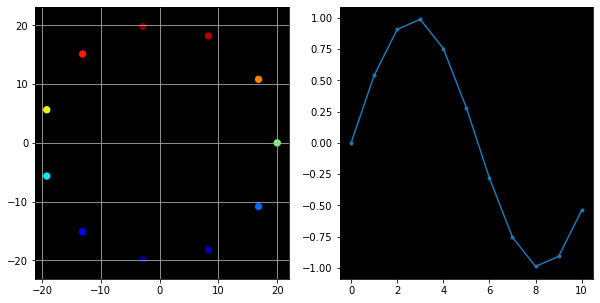

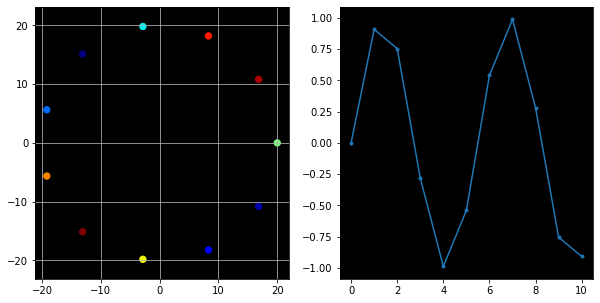

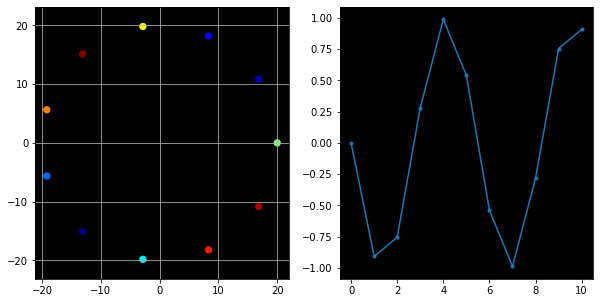

In [7]:
# The force densities in each trail line (connections from the top to the fixed points) are connected via a trigonometric function
def vis_harmonic(Amp=1,freq=2,phase_s=0):
    # Here, we need to assign 11 values for each path from the top to the supports (fixed points)
    n_rows = 11
    facecolor = 'black'
    phase_s = phase_s*np.pi
    angles = [(freq*np.pi*float(k)/n_rows)-phase_s for k in range(0,n_rows)]
    vals = Amp*np.sin(angles)
    
    r = 20
    center = [0,0]
    angles = [2*np.pi*i/n_rows for i in range(n_rows)]
    xy_fixed_nodes = [[r*np.cos(a),r*np.sin(a)] for a in angles]
    xy_fixed_nodes = np.asarray(xy_fixed_nodes)
    
    mn = np.min(vals)
    mx = np.max(vals)
    fig = plt.figure(figsize=(10,5))
    ax  = plt.subplot(1,2,1)
    ax.set_facecolor(facecolor)
    plt.scatter(xy_fixed_nodes[:,0],xy_fixed_nodes[:,1],s=40,c=vals,cmap=plt.cm.jet,vmin=mn,vmax=mx);
    plt.grid();
    plt.axis('equal');
    ax  = plt.subplot(1,2,2)
    ax.set_facecolor(facecolor)
    plt.plot(vals,'.-');
vis_harmonic(Amp=1,freq=2,phase_s=0)
vis_harmonic(Amp=1,freq=4,phase_s=0)
vis_harmonic(Amp=1,freq=4,phase_s=-1)

In [8]:
interact(vis_harmonic,
         Amp=FloatSlider(1.0,min=-5,max=20,step=.1),
         freq=FloatSlider(2.0,min=0,max=100,step=1),
         phase_s=FloatSlider(0.0,min=-2,max=2,step=.5))

interactive(children=(FloatSlider(value=1.0, description='Amp', max=20.0, min=-5.0), FloatSlider(value=2.0, de…

<function __main__.vis_harmonic>

In [18]:
def parametric_solver(Data_struct,
                      p_z=.1,
                      base_radius=10,
                      Amp_trail=1,
                      phase_trail=0,
                      coef_trail=2,
                      fixed_minimum_trail=.3,
                      Amp_deviation=1,
#                       phase_deviation=0,
#                       coef_deviation=2,
                      plot_interactive = True,
                      verbose=True,
                      plot_form_projection=False
                     ):
    n_free_nodes = len(Data_struct['free_nodes'])
    n_fixed_nodes = len(Data_struct['fixed_nodes'])
    n_cols = np.max(DF_edges['col_number'])+1
    n_rows = np.max(DF_edges['row_number'])+1
    r = base_radius
    center = [0,0]
    angles = [2*np.pi*i/n_cols for i in range(n_cols)]
    xy_fixed_nodes = [[r*np.cos(a),r*np.sin(a)] for a in angles]
    xy_fixed_nodes = np.asarray(xy_fixed_nodes)
    z_f = 0*np.ones(n_fixed_nodes) - 0.0*np.random.randn(n_fixed_nodes)
    x_f = xy_fixed_nodes[:,0]
    y_f = xy_fixed_nodes[:,1]
    p_x = .0*np.ones((n_free_nodes)) + 0.0*np.random.randn(n_free_nodes)
    p_y = -.0*np.ones((n_free_nodes))
    p_z = p_z*np.ones((n_free_nodes))
    q = np.ones(DF_edges.shape[0])
    q = np.zeros(DF_edges.shape[0])
    eps = .00001
    # give the same value to vertical elements in each row
    # Trail members
    factor = np.random.choice(range(n_cols),size=n_cols,replace=False)
    factor = range(n_cols)
    for i in range(n_cols):
        ind_ = DF_edges.loc[(DF_edges['col_number']==i) & (DF_edges['is_vertical']==1)].index[:].values[:]
        Amp = Amp_trail*(0+1)/1.0
        freq = coef_trail
#         factor = np.random.randint(-1,high=2,size=1)[0]
        
        phase_s = (factor[i]+phase_trail)*np.pi
        angles = [(freq*np.pi*float(k)/(n_rows-1))-phase_s for k in range(0,n_rows-1)]
        vals = Amp*np.sin(angles) + fixed_minimum_trail
        
#         vals = .1
        
        if len(ind_)>1:
            q[ind_] = vals

    # give the same value in horizontal edges in each column
#     Deviation
    for i in range(n_rows):
        ind_ = DF_edges.loc[(DF_edges['row_number']==i) & (DF_edges['is_vertical']==0)].index[:].values[:]
        vals = Amp_deviation*(i+1)
#         rnd_factor = n_rows*np.random.rand()
#         vals = Amp_deviation*(np.sign(rnd_factor)*np.abs(rnd_factor))
#         print (vals)
        if len(ind_)>1:
            q[ind_] = vals
    n_free_edges = len(Data_struct['free_edges'])
    n_free_nodes = len(Data_struct['free_nodes'])
    Data_struct['q'] = q
    Data_struct['p_x'] = p_x
    Data_struct['p_y'] = p_y
    Data_struct['p_z'] = p_z
    Data_struct['x_f'] = x_f
    Data_struct['y_f'] = y_f
    Data_struct['z_f'] = z_f
    
    
    # Now solve FDM
    Data_struct = FdmSolver.solve_fdm_Sheck(Data_struct,plot_topologies=False)
    Data_struct = FdmSolver.cal_loadpath(Data_struct)
    
    if plot_form_projection == True:
        FdmSolver.plot_form_static(Data_struct)
    
    if verbose == True:
        print ('loadpath:{}'.format(FdmSolver.cal_loadpath(Data_struct)['loadpath']))
    if plot_interactive == True:
        FdmSolver.plot_form_interactive(Data_struct,fixed_node_size=.71)
    
    return Data_struct

In [19]:
from fdmlib import fdm
import sys,importlib
importlib.reload(fdm)
FdmSolver = fdm.FDM()
_ = interactive(parametric_solver,
         Data_struct=fixed(Data_struct),
         p_z = FloatSlider(0.5,min=.0,max=2,step=.01),
         base_radius = FloatSlider(20.0,min=1,max=200,step=1),
         Amp_trail=FloatSlider(0.0,min=-5,max=10,step=.05),
         phase_trail=FloatSlider(0.0,min=-2,max=2,step=.05),
         coef_trail=FloatSlider(1.0,min=-20,max=20,step=.1),
         fixed_minimum_trail = FloatSlider(0.3,min=0.0,max=4,step=0.1),
         Amp_deviation=FloatSlider(.05,min=-1,max=1,step=.01),
#          phase_deviation = FloatSlider(0.0,min=-2,max=2,step=.05),
#          coef_deviation=FloatSlider(1.0,min=-20,max=20,step=1),
         plot_interactive = True,
         verbose=fixed(True),
         plot_form_projection=False
        );
display(_)

interactive(children=(FloatSlider(value=0.5, description='p_z', max=2.0, step=0.01), FloatSlider(value=20.0, d…

# Use of Machine Learning to explore the design space
- We generate few thousands of geometries by varying the parameters we defined above
- We use Self Organizing Maps (SOM) to cluster the final geometries based on their similarities
- Here, defining, similarity measure depends on the user. Here, we use Higher Order Statistics (HOS) of distribution of Forces, Lengths of edges and load-path (force*length). We use four first moments (mean, standard deviation, Skewness and Kurtosis). All together 12 variables to represent the final geometries. 
- SOM is used as a dimensionality reduction, data reduction (i.e. clustering) as well multi-dimensional sorting. 
- For further details, refer to "Karla Saldana Ochoa, Patrick Ole Ohlbrock, Pierluigi D’acunto, Vahid Moosavi, beyond typologies, beyond optimization, IASS Annual Symposium 2019 - Structural Membranes 2019, Form and Force, 7–10 October 2019, Barcelona, Spain."
- [Higher Order Statistics](https://en.wikipedia.org/wiki/Higher-order_statistics)
- Self Organizing Maps in Python: [SOMPY](https://github.com/sevamoo/SOMPY)


# Generating geometries by randomly choosing the values of the defined parameters:
- For each column we use a trigonometric function with three parameters.
- For each row we use a fixed value for the density in the deviation members.

In [20]:



all_combinations = []

for i in range(10000):
    if i%500==0:
        print (i)
    Amp_trail = -5+ 10*np.random.rand()
    phase_trail = -2+ 4*np.random.rand()
    coef_trail = -(n_rows-1)*4+ 2*((n_rows-1)*4)*np.random.rand() 
    fixed_minimum_trail= 0.0 + 4*np.random.rand()
    Amp_deviation= -1+ 2*np.random.rand()
    params = [Amp_trail] + [phase_trail] + [coef_trail] + [fixed_minimum_trail] + [Amp_deviation]
    Input_params_names = ['Amp_trail','phase_trail','coef_trail','fixed_minimum_trail','Amp_deviation']
    experiment = {}
    try:
        res = parametric_solver(Data_struct,
                      p_z=.5,
                      base_radius=20,
                      Amp_trail=Amp_trail,
                      phase_trail=phase_trail,
                      coef_trail=coef_trail,
                      fixed_minimum_trail=fixed_minimum_trail,
                      Amp_deviation=Amp_deviation,
                      plot_interactive = False,
                      verbose=False,
                      plot_form_projection=False
                     )


        experiment['result'] = res.copy()
        experiment['input_parameters'] = params
        all_combinations.append(experiment)
    except:
        pass


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [21]:
# Save all results
# for i in range(len(all_combinations)):
#     file_name = 'stadium_{}.npy'.format(i)
#     json_file  = './Data/Sample_results/'+file_name
#     np.save(json_file, all_combinations[i]) 

In [22]:
# Load sample results
# path = './Data/Sample_results/'
# filenames = []
# for filename in glob.glob(os.path.join(path, '*.npy')):
#     filenames.append(filename)
# filenames = np.sort(filenames)
# print (len(filenames))

# all_combinations = [np.load(fn,allow_pickle='TRUE').item() for fn in filenames[:]]

In [23]:
len(all_combinations)

10000

In [24]:
DF_all_combinations = pd.DataFrame()
tmp = [ex['result'] for ex in all_combinations] 
DF_all_combinations['result'] = tmp
XYZ_coords = [ex['result']['final_positions'] for ex in all_combinations] 
XYZ_coords = np.asarray(XYZ_coords)
print (XYZ_coords.shape)
Xcoords = pd.DataFrame(data=XYZ_coords[:,0,0])
Ycoords = pd.DataFrame(data=XYZ_coords[:,0,1])
Zcoords = pd.DataFrame(data=XYZ_coords[:,0,2])
Lengths = [ex['result']['edgelenght'] for ex in all_combinations] 
Lengths = np.asarray(Lengths)
Lengths = pd.DataFrame(data=Lengths)
print (Lengths.shape)
Forces = [ex['result']['q'] for ex in all_combinations] 
Forces = np.asarray(Forces)
Forces = pd.DataFrame(data=Forces)
print (Forces.shape)
Input_parameters = [ex['input_parameters'] for ex in all_combinations] 
Input_parameters = np.asarray(Input_parameters)
LoadPaths_abs = np.multiply(np.abs(Forces.values[:]),Lengths.values[:])
LoadPaths = np.multiply(Forces.values[:],Lengths.values[:])

(10000, 288, 3)
(10000, 528)
(10000, 528)


In [25]:
Input_parameters.shape

(10000, 5)

In [26]:
n_free_edges = len(Data_struct['free_edges'])
def vis_(ind_experiment=0,plot_form_projection = True,verbose = False,plot_interactive = False):    
    DD = DF_all_combinations['result'].values[ind_experiment].copy()
    if plot_form_projection == True:
        FdmSolver.plot_form_static(DD)
    if verbose == True:
        print ('loadpath:{}'.format(DD['loadpath']))
    if plot_interactive == True:
        FdmSolver.plot_form_interactive(DD,fixed_node_size=.71)
        
interact(vis_,ind_experiment=IntSlider(0,0,len(all_combinations),1))

interactive(children=(IntSlider(value=0, description='ind_experiment', max=10000), Checkbox(value=True, descri…

<function __main__.vis_>

In [27]:
from scipy.stats import kurtosis
from scipy.stats import skew

#mean of Forces
mean_Forces  =  Forces.mean(axis=1)
# mean of abs(Forces)
mean_abs_Forces  =  np.abs(Forces.values[:]).mean(axis=1)
#variance of Forces
std_Forces = Forces.std(axis=1)
#variance of absolute Forces
std_abs_Forces = np.abs(Forces.std(axis=1))
#Skewness Forces
skw_Forces = skew(Forces.values[:],axis=1)
#Skewness of absolute Forces
skw_abs_Forces = np.abs(skew(Forces.values[:],axis=1))
#Kurtosis of Forces
kurt_Forces = kurtosis(Forces.values[:],axis=1)
#Kurtosis of absolute Forces
kurt_abs_Forces = kurtosis(np.abs(Forces.values[:]),axis=1)


#mean of Lengths
mean_Lengths  =  Lengths.mean(axis=1)
#variance of Lengths
std_Lengths = Lengths.std(axis=1)
#Skewness Lengths
skw_Lengths = skew(Lengths.values[:],axis=1)
#Kurtosis of Lengths
kurt_Lengths = kurtosis(Lengths.values[:],axis=1)



#mean of LoadPaths
mean_LoadPaths  =  LoadPaths.mean(axis=1)
# mean of abs(LoadPaths)
mean_abs_LoadPaths  =  np.abs(LoadPaths).mean(axis=1)
#variance of LoadPaths
std_LoadPaths = LoadPaths.std(axis=1)
#variance of absolute LoadPaths
std_abs_LoadPaths = np.abs(LoadPaths.std(axis=1))
#Skewness LoadPaths
skw_LoadPaths = skew(LoadPaths,axis=1)
#Skewness of absolute LoadPaths
skw_abs_LoadPaths = np.abs(skew(LoadPaths,axis=1))
#Kurtosis of LoadPaths
kurt_LoadPaths = kurtosis(LoadPaths,axis=1)
#Kurtosis of absolute LoadPaths
kurt_abs_LoadPaths = kurtosis(np.abs(LoadPaths),axis=1)


#mean of LoadPaths_abs
mean_LoadPaths_abs  =  LoadPaths_abs.mean(axis=1)
# mean of abs(LoadPaths_abs)
mean_abs_LoadPaths_abs  =  np.abs(LoadPaths_abs).mean(axis=1)
#variance of LoadPaths_abs
std_LoadPaths_abs = LoadPaths_abs.std(axis=1)
#variance of absolute LoadPaths_abs
std_abs_LoadPaths_abs = np.abs(LoadPaths_abs.std(axis=1))
#Skewness LoadPaths_abs
skw_LoadPaths_abs = skew(LoadPaths_abs,axis=1)
#Skewness of absolute LoadPaths_abs
skw_abs_LoadPaths_abs = np.abs(skew(LoadPaths_abs,axis=1))
#Kurtosis of LoadPaths_abs
kurt_LoadPaths_abs = kurtosis(LoadPaths_abs,axis=1)
#Kurtosis of absolute LoadPaths_abs
kurt_abs_LoadPaths_abs = kurtosis(np.abs(LoadPaths_abs),axis=1)





#mean of Xcoords
mean_Xcoords  =  Xcoords.mean(axis=1)
# mean of abs(Coords)
mean_abs_Xcoords  =  np.abs(Xcoords).mean(axis=1)
#variance of Coords
std_Xcoords = Xcoords.std(axis=1)
#variance of absolute Coords
std_abs_Xcoords = np.abs(Xcoords.std(axis=1))
#Skewness Coords
skw_Xcoords = skew(Xcoords,axis=1)
#Skewness of absolute Coords
skw_abs_Xcoords = np.abs(skew(Xcoords,axis=1))
#Kurtosis of Coords
kurt_Xcoords = kurtosis(Xcoords,axis=1)
#Kurtosis of absolute Coords
kurt_abs_Xcoords = kurtosis(np.abs(Xcoords),axis=1)



#mean of Ycoords
mean_Ycoords  =  Ycoords.mean(axis=1)
# mean of abs(Coords)
mean_abs_Ycoords =  np.abs(Ycoords).mean(axis=1)
#variance of Coords
std_Ycoords = Ycoords.std(axis=1)
#variance of absolute Coords
std_abs_Ycoords = np.abs(Ycoords.std(axis=1))
#Skewness Coords
skw_Ycoords = skew(Ycoords,axis=1)
#Skewness of absolute Coords
skw_abs_Ycoords = np.abs(skew(Ycoords,axis=1))
#Kurtosis of Coords
kurt_Ycoords = kurtosis(Ycoords,axis=1)
#Kurtosis of absolute Coords
kurt_abs_Ycoords = kurtosis(np.abs(Ycoords),axis=1)


#mean of Ycoords
mean_Zcoords  =  Zcoords.mean(axis=1)
# mean of abs(Coords)
mean_abs_Zcoords =  np.abs(Zcoords).mean(axis=1)
#variance of Coords
std_Zcoords = Zcoords.std(axis=1)
#variance of absolute Coords
std_abs_Zcoords = np.abs(Zcoords.std(axis=1))
#Skewness Coords
skw_Zcoords = skew(Zcoords,axis=1)
#Skewness of absolute Coords
skw_abs_Zcoords = np.abs(skew(Zcoords,axis=1))
#Kurtosis of Coords
kurt_Zcoords = kurtosis(Zcoords,axis=1)
#Kurtosis of absolute Coords
kurt_abs_Zcoords = kurtosis(np.abs(Zcoords),axis=1)




In [28]:
DF_analytics = pd.DataFrame()
DF_analytics['Forces mean'] = mean_Forces
# DF_analytics['Abs Forces mean'] = mean_abs_Forces
DF_analytics['Forces std'] = std_Forces
# DF_analytics['Abs Forces std'] = std_abs_Forces
DF_analytics['Forces skw'] = skw_Forces
# DF_analytics['skw abs Forces'] = skw_abs_Forces
DF_analytics['Forces kurt']=kurt_Forces
# DF_analytics['kurt abs Forces'] = kurt_abs_Forces




DF_analytics['Lengths mean'] = mean_Lengths
DF_analytics['Lengths std'] = std_Lengths
DF_analytics['Lengths skw'] = skw_Lengths
DF_analytics['Lengths kurt'] = kurt_Lengths


# here, we took abs load path as load path just for simplicity
DF_analytics['Load paths mean'] = mean_LoadPaths_abs
# DF_analytics['mean_abs_LoadPaths'] = mean_abs_LoadPaths
DF_analytics['Load paths std'] = std_LoadPaths_abs
# DF_analytics['std_abs_LoadPaths'] = std_abs_LoadPaths
DF_analytics['Load paths skw'] = skw_LoadPaths_abs
# DF_analytics['skw_abs_LoadPaths'] = skw_abs_LoadPaths
DF_analytics['Load paths kurt']=kurt_LoadPaths_abs
# DF_analytics['kurt_abs_LoadPaths'] = kurt_abs_LoadPaths


# DF_analytics['mean_LoadPaths_abs'] = mean_LoadPaths_abs
# # DF_analytics['mean_abs_LoadPaths_abs'] = mean_abs_LoadPaths_abs
# DF_analytics['std_LoadPaths_abs'] = std_LoadPaths_abs
# # DF_analytics['std_abs_LoadPaths_abs'] = std_abs_LoadPaths_abs
# DF_analytics['skw_LoadPaths_abs'] = skw_LoadPaths_abs
# # DF_analytics['skw_abs_LoadPaths_abs'] = skw_abs_LoadPaths_abs
# DF_analytics['kurt_LoadPaths_abs']=kurt_LoadPaths_abs
# # DF_analytics['kurt_abs_LoadPaths_abs'] = kurt_abs_LoadPaths_abs




print (DF_analytics.shape)
DF_analytics.head()

(10000, 12)


,Forces mean,Forces std,Forces skw,Forces kurt,Lengths mean,Lengths std,Lengths skw,Lengths kurt,Load paths mean,Load paths std,Load paths skw,Load paths kurt
0,1.400552,2.524269,1.104292,-0.033187,20.571313,27.360074,1.255291,0.237999,14.561627,22.287390,1.489439,0.549378
1,3.437100,2.487026,0.106903,-0.671475,1.929271,1.685833,1.741640,3.359197,5.614847,5.630988,2.600435,7.933790
2,4.302162,2.808049,0.300504,-0.821463,1.817861,1.805642,1.291868,1.007585,4.674525,3.845214,1.170459,1.330803
3,-0.361045,4.631162,-0.240127,-1.539911,4.486321,3.786833,1.237860,0.308079,15.607602,9.373135,0.948337,0.814853
4,-0.111435,1.913773,0.700431,-0.682580,3.381802,1.269899,-0.584763,-0.858044,5.234578,3.889722,0.997090,0.127665


In [29]:
HOS_stat = DF_analytics.describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99])
HOS_stat
# HOS_stat['Forces mean']

,Forces mean,Forces std,Forces skw,Forces kurt,Lengths mean,Lengths std,Lengths skw,Lengths kurt,Load paths mean,Load paths std,Load paths skw,Load paths kurt
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.999035,2.768390,0.195622,-0.878645,22.366275,21.719842,1.025391,1.112504,41.805616,36.472751,1.150237,1.170967
std,2.099697,1.187537,0.515632,0.438398,233.709031,268.563236,0.815074,2.657635,362.946382,360.908477,0.633999,2.146703
min,-3.464547,0.137342,-1.150857,-1.998982,1.642208,1.005402,-0.905692,-1.922638,1.500118,1.625031,-0.357464,-1.834847
10%,-1.826260,1.259901,-0.443124,-1.424440,1.853540,1.358301,0.079547,-1.000020,3.427693,2.632724,0.412910,-0.768852
20%,-1.103298,1.706165,-0.288527,-1.244958,2.154848,1.609427,0.334125,-0.793518,4.406210,3.444195,0.599993,-0.499613
30%,-0.385746,2.057794,-0.151082,-1.107229,3.030177,2.002485,0.536752,-0.570430,5.379917,4.379839,0.767608,-0.230218
40%,0.315775,2.354491,-0.018219,-0.986152,4.133269,2.590956,0.692459,-0.333801,7.329474,5.890249,0.898894,0.091401
50%,1.003944,2.653424,0.123220,-0.885937,5.146745,3.448111,0.890291,0.028403,10.834807,8.038113,1.053644,0.411790
60%,1.701311,2.964954,0.305108,-0.807570,6.571613,4.973546,1.102731,0.593015,14.352395,10.694496,1.213110,0.860330


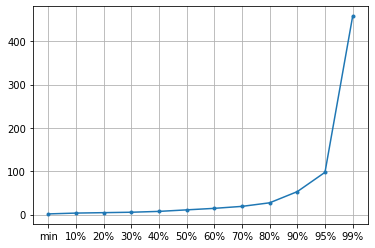

In [30]:
plt.plot(HOS_stat['Load paths mean'].values[3:-1],'.-');
ticks = list(HOS_stat.index.values[3:-1])
plt.xticks([i for i in range(len(ticks))],ticks)
plt.grid()

# Organizing (multi-dimensional ordering of the generated geometries) using Self Organizing Maps (SOM)

In [31]:
ind_sel = DF_analytics['Load paths mean']<=HOS_stat['Load paths mean'].loc['80%']
print (DF_analytics.shape)
XX = DF_analytics.values[ind_sel].astype(float)
YY = Input_parameters[ind_sel]
columns = np.asarray(list(DF_analytics.columns.values[:])+Input_params_names)
# X = np.concatenate((XX,YY),axis=1)
# X = YY
# columns = columns[-5:]

X = XX
columns = columns[range(XX.shape[1])]

std_x = np.std(X,axis=0)
print (X.shape)
X = X[:,std_x>0]
print (X.shape)

(10000, 12)
(8000, 12)
(8000, 12)


In [44]:



###############
# For this we need a proper data set as csv
###############


import sompylib.sompy as SOM
msz10 = 50
msz11 =50


# X = DF_analytics.values[:].astype(float)

print (X.shape)
som = SOM.SOM('', X[:], mapsize = [msz10, msz11],norm_method = 'var',initmethod='pca')
som.train(n_job = 1, shared_memory = 'no',verbose='final')
som.compname=[columns]

(8000, 12)
Total time elapsed: 4.888000 secodns
final quantization error: 0.771733


In [45]:
dists,bmus = som.find_K_nodes(som.data_raw,K=1)

# Now each dot shows the cluster of geometries which have similar characteristics.

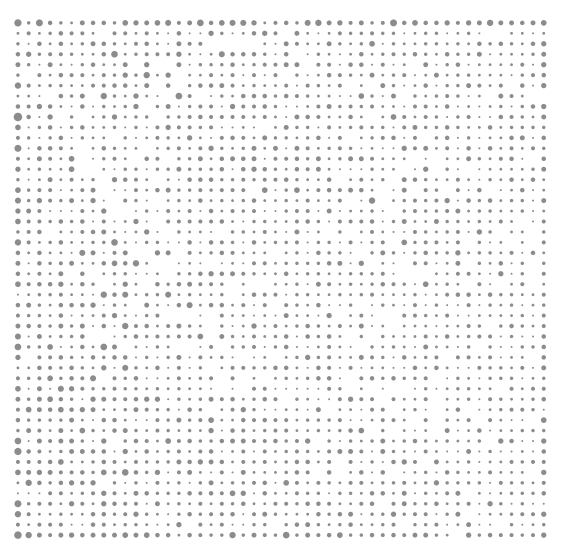

In [46]:
som.hit_map(col='gray')

# Now we can visualize the corresponding colors of each of the measures we used to represent the generated geometries

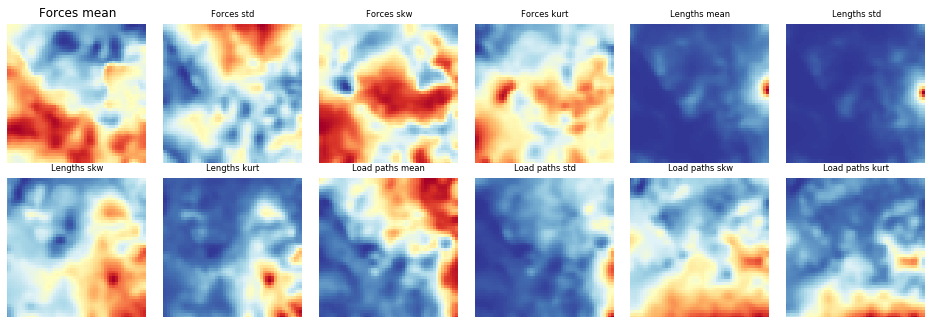

In [55]:
if X.shape[1]>35:
    pass
else:
    som.view_map(text_size=7)

In [56]:
xy_option = som.ind_to_xy(bmus[:,0])
xx = xy_option[:,1]
yy = som.mapsize[0]- xy_option[:,0]


8000

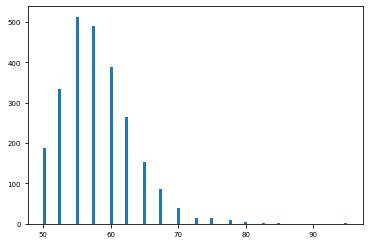

In [57]:
# bmus
# freq_bmus = [15000*np.sum(bmus==i)/som.nnodes for i in range(som.nnodes) ]
# plt.hist(freq_bmus,bins=100);

bmus
freq_bmus = [50+20000*np.sum(bmus==i)/len(bmus) for i in range(som.nnodes)]
plt.hist(freq_bmus,bins=100);
freq_bmus = [freq_bmus[bm[0]] for bm in bmus]
len(freq_bmus)

# making query on the trained SOM
- Now we can make queries on the clusters based on any of the factors (e.g. load path mean or length skewness) and pick those geometries within those clusters. 
- The key point here is that this is not a typical query on the data points. Here, we query nodes of the SOM, based on one or two features, but the data points within each node are placed there considering all the features together. This result cannot be achieved by other "dimensionality reduction" methods like T-SNE or UMAP. SOM has additional aspect which is performing both data reduction and dimensionality reduction together.

In [50]:
def show_node(ind=0):    
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    node_n = ind_sel_nodes[ind]
    print ('node number: ',node_n)
    cases = np.argwhere(bmus==node_n)[:,0]    
    K = len(cases)
    if K>=1:
        #Sort within each cluster
        DF_tmp = pd.DataFrame()
        DF_tmp['data_inds'] = cases
        DF_tmp['dists'] = dists[cases]
        data_inds = DF_tmp.sort_values('dists')['data_inds'].copy().values[:]
        facecolor = 'black'
        fig = plt.figure(figsize=(30,10),facecolor=facecolor)
        for f in range(6):
            try:
                data_ind = data_inds[f]
                G = Data_struct['G']
                all_poses = Data_struct['all_poses']
                ax = fig.add_subplot(2,6,f+1)                
                ax.set_facecolor(facecolor)
#                 ax.set_facecolor(facecolor)
                DD = DF_all_combinations['result'].values[ind_sel][data_ind]
#                 ax  = plt.subplot(1,2,1)
                G = DD['G']
                
                xy_poses = DD['all_poses']
                xy_poses = {}
                coords = DD['final_positions'].copy()
                for i in range(coords.shape[0]):
                    xy_poses[i]=coords[i,[0,1]]
                
                
                G = DD['G']
                BG =DD['base_G']
                q = DD['q']
                edge_colors = dict(BG.edges)
                for i,e in enumerate(G.edges):
                    edge_colors[e] = q[i]
                for e in set(BG.edges).difference(G.edges):
                    edge_colors[e] = 4.
                col = np.asarray(list(edge_colors.values())).copy()
#                 col = DD['q'].copy()
                col[col>=0] = .85
                col[col<0] = .15
                w = 0.5+ np.abs(DD['q'].copy()).copy()

                nx.draw_networkx(BG,
                             pos=xy_poses,
                             arrows=False,
                             edge_color = list(col),
                             edge_cmap = plt.cm.RdYlBu_r,
                             edge_vmin = 0,
                             edge_vmax = 1.,
                             width = 1,
                             with_labels=False,
                             font_color='white',
                             node_size=.01,
                             node_color = 'w',  
                             alpha=1)
                ax.set_aspect('equal', 'box')
                ax = fig.add_subplot(2,6,1*6+f+1)
                ax.set_facecolor(facecolor)
#                 ax  = plt.subplot(1,2,2)
                xz_poses = {}
                coords = DD['final_positions'].copy()
                for i in range(coords.shape[0]):
                    xz_poses[i]=coords[i,[0,2]]
                nx.draw_networkx(BG,
                             pos=xz_poses,
                             arrows=False,
                             edge_color = list(col),
                             edge_cmap = plt.cm.RdYlBu_r,
                             edge_vmin = 0,
                             edge_vmax = 1.,
                             width = 1,
                             with_labels=False,
                             font_color='white',
                             node_size=.01,
                             node_color = 'w',  
                             alpha=1)      
                ax.set_aspect('equal', 'box')
                plt.tight_layout()
            except:
                pass        
            plt.tight_layout( )
        plt.show()
    else:
        print ('not enough data for this node')

In [51]:
codebooks = SOM.denormalize_by(som.data_raw,som.codebook)
unq_bmus = np.unique(bmus)
xy_som = som.ind_to_xy(unq_bmus)


def query_nodes_new(Measure1='Load paths mean',percentRange1=[3,99],Measure2='Load paths mean',percentRange2=[1,99],plot='Yes'):
    from IPython.display import clear_output, Image, display
  
    codebooks = SOM.denormalize_by(som.data_raw,som.codebook)
#     codebooks = codebooks[unq_bmus]
    DF_som = pd.DataFrame(data=codebooks,columns=list(som.compname[0]))
    percentiles = list(set(percentRange1).union(percentRange2))
    percentiles = list(np.sort(percentiles)/100.0)
    som_stat = DF_som.describe(percentiles=percentiles)
    try:
        
        ind_sel_nodes = DF_som.loc[
            (DF_som[Measure1] >= som_stat.ix[str(percentRange1[0])+'%'][Measure1])
            &
            (DF_som[Measure1] <= som_stat.ix[str(percentRange1[1])+'%'][Measure1])
            &
            (DF_som[Measure2] >= som_stat.ix[str(percentRange2[0])+'%'][Measure2])
            &
            (DF_som[Measure2] <= som_stat.ix[str(percentRange2[1])+'%'][Measure2])
        ].index.values[:]

        if plot=='Yes':
            xy_sel = som.ind_to_xy(ind_sel_nodes)            
            fig = plt.figure(figsize=(16,16))
            plt.rcParams.update({'font.size': 10})
            
            for i in range(codebooks.shape[1]):
                
                ax = fig.add_subplot(5,4,i+1)
                col = codebooks[unq_bmus,i]
                mn = col.min()
                mx = col.max()
                col = codebooks[ind_sel_nodes,i]
                x = xy_sel[:,1]*1  
                y = som.mapsize[0]-1-xy_sel[:,0]*1 
                sc = ax.scatter(x,y,s=20,c=col,cmap=plt.cm.RdYlBu_r,edgecolor='None',vmax=mx,vmin=mn,marker='o',alpha=1.);
                eps = .8
                plt.xlim(x.min()-eps,x.max()+eps)
                plt.ylim(y.min()-eps,y.max()+eps)
                plt.colorbar(sc,shrink=.5,ticks=[mn,(mn+mx)/2.0,mx])
                plt.title(som.compname[0][i])
                plt.tight_layout(pad=0.001, h_pad=0.0, w_pad=0.0)
                plt.xlim(0,som.mapsize[0]-1);
                plt.ylim(0,som.mapsize[1]-1);
                plt.xticks([]);
                plt.yticks([]);
        return ind_sel_nodes
    except:
        print ('change the values of the sliders')
        return

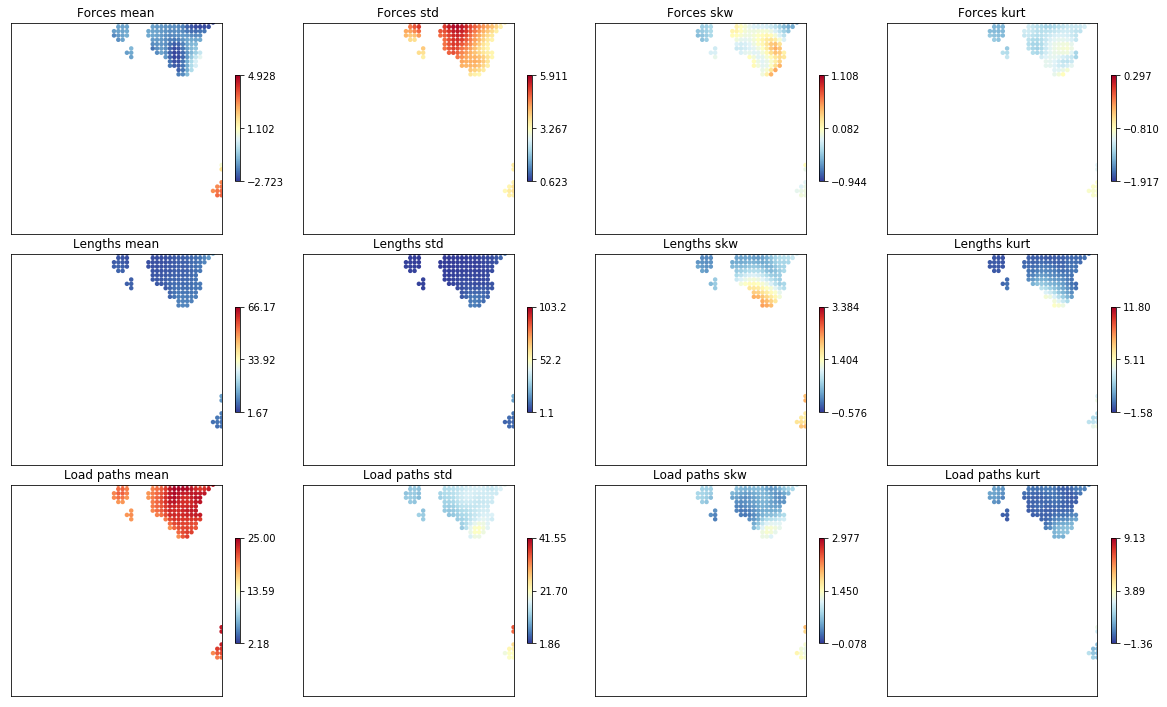

In [70]:
ind_ = query_nodes_new(Measure1='Load paths mean',percentRange1=[87,100],Measure2='Forces std',percentRange2=[80,100],plot='Yes')

node number:  73


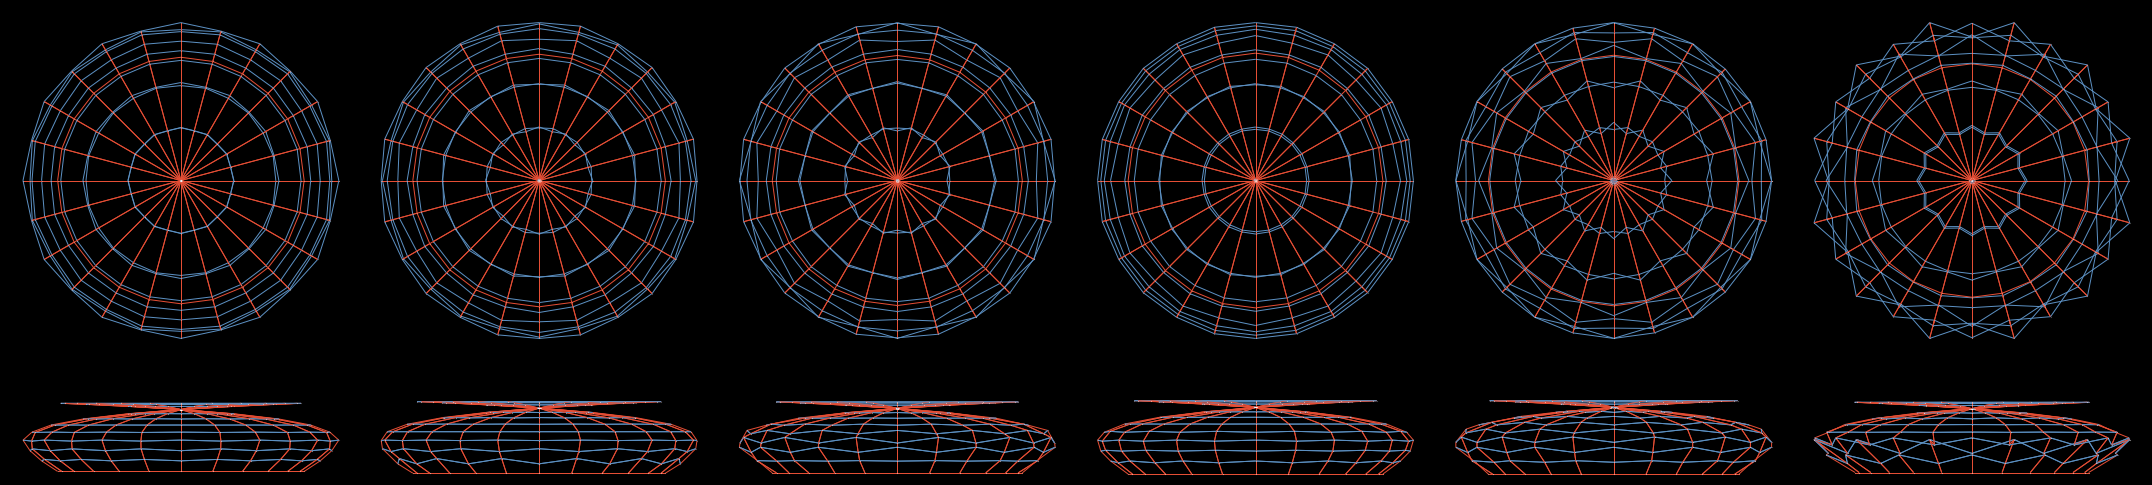

In [68]:
show_node(ind=21)

# Interactive

In [52]:
from ipywidgets import interact, HTML, FloatSlider, interactive
from IPython.display import display
import ipywidgets as widgets

codebooks = SOM.denormalize_by(som.data_raw,som.codebook)
DF_som = pd.DataFrame(data=codebooks,columns=som.compname)
som_stat = DF_som.describe(percentiles=[0.0,.01,.05,.1,.29,.3,.4,.5,.6,.7,.8,.9,.95,.99,1])
what_measures = [i[0] for i in som_stat.columns.values[:]]
percents = [i for i in som_stat.index.values[4:-1]]
# smallerorlarger = ['smaller','larger']



items = [widgets.Label(str(i)) for i in range(4)]
left_box = widgets.VBox([items[0], items[1]])
right_box = widgets.VBox([items[2], items[3]])
widgets.HBox([left_box, right_box])
Drop_what_measures1 = widgets.Dropdown(
    # value='John',
    placeholder=what_measures[0],
    options=what_measures,
    description='Measure 1',
    ensure_option=True,
    disabled=False
)

double_percentage1 = widgets.IntRangeSlider(
    value=[0, 100],
    min=0,
    max=100,
    step=1,
#     options = percents,
    description='Percentage',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
col1 = widgets.VBox([Drop_what_measures1,double_percentage1])



Drop_what_measures2 = widgets.Dropdown(
    # value='John',
    placeholder=what_measures[0],
    options=what_measures,
    description='Measure 2',
    ensure_option=True,
    disabled=False
)

double_percentage2 = widgets.IntRangeSlider(
    value=[0, 100],
    min=0,
    max=100,
    step=1,
#     options = percents,
    description='Percentage',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
col2 = widgets.VBox([Drop_what_measures2,double_percentage2])

menu_hbox = widgets.HBox([col1,col2])

menu = interactive(query_nodes_new,
                    Measure1=Drop_what_measures1,percentRange1=double_percentage1, 
                   Measure2=Drop_what_measures2,
                    percentRange2=double_percentage2,     
                    
                    plot='Yes')
display(menu)

interactive(children=(Dropdown(description='Measure 1', options=('Forces mean', 'Forces std', 'Forces skw', 'F…

In [59]:
from ipywidgets import interact, HTML, FloatSlider
import ipywidgets as widgets
menu.kwargs
# ind_sel_nodes = query_nodes(what=menu.kwargs['what'],smallerorlarger=menu.kwargs['smallerorlarger'],percent=menu.kwargs['percent'],plot='No')
ind_sel_nodes = query_nodes_new(
                                Measure1=menu.kwargs['Measure1'],
                                percentRange1=menu.kwargs['percentRange1'], 
                                Measure2=menu.kwargs['Measure2'],
                                percentRange2=menu.kwargs['percentRange2'],     
                                plot='No')
interact(show_node,ind=widgets.IntSlider(min=0,max=len(ind_sel_nodes)-1,step=1,value=0));

interactive(children=(IntSlider(value=0, description='ind', max=213), Output()), _dom_classes=('widget-interac…